In [1]:
%matplotlib inline
from pylab import *
import cv2

## Some Misc Functions

In [2]:
def get_threshold_im(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # thresholding
    threshold_im=((gray<120)*255).astype(np.uint8)

    h, w = threshold_im.shape[:2]
    
    cv2.floodFill(threshold_im,None,(0,0),0)
    cv2.floodFill(threshold_im,None,(w-1,0),0)
    cv2.floodFill(threshold_im,None,(w-1,h-1),0)
    cv2.floodFill(threshold_im,None,(0,h-1),0)    
    return threshold_im


In [3]:
def find_corners(image,threshold_im=None):
    if threshold_im is None:
        threshold_im=get_threshold_im(image)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(threshold_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    
    # Find the contour that best matches the game board
    board_contour = None
    for contour in contours:
        # Approximate the contour to reduce the number of points
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Check if this contour has 4 points (for a rectangular shape)
        if len(approx) == 4:
            board_contour = approx
            break
    
    if board_contour is not None:
        # Sort the corners in the order: top-left, top-right, bottom-right, bottom-left
        corners = np.array([point[0] for point in board_contour])
        sum_pts = corners.sum(axis=1)
        diff_pts = np.diff(corners, axis=1)
        top_left = corners[np.argmin(sum_pts)]
        bottom_right = corners[np.argmax(sum_pts)]
        top_right = corners[np.argmin(diff_pts)]
        bottom_left = corners[np.argmax(diff_pts)]
        ordered_corners = np.array([top_left, top_right, bottom_right, bottom_left], dtype="float32")
    else:
        print("Could not find a rectangular contour in the image.")    
        ordered_corners=None
        
    return ordered_corners

In [4]:
def straighten_image(image,corners=None):
    if corners is None:
        corners=find_corners(image)

    top_left, top_right, bottom_right, bottom_left=corners
    # Define the width and height of the new "top-down" view
    width = int(max(
        np.linalg.norm(bottom_right - bottom_left),
        np.linalg.norm(top_right - top_left)
    ))
    height = int(max(
        np.linalg.norm(top_right - bottom_right),
        np.linalg.norm(top_left - bottom_left)
    ))

    # Define the destination points for the perspective transform
    destination_corners = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")

    # Compute the perspective transform matrix
    matrix = cv2.getPerspectiveTransform(corners, destination_corners)
    
    # Apply the perspective transformation
    warped_image = cv2.warpPerspective(image, matrix, (width, height))

    return warped_image


In [5]:
def get_board_squares_from_image(image,board_size,square_size=(60,60)):
    nr,nc=board_size
    
    squares=[]
    pix_row=image.shape[0]//nr
    pix_col=image.shape[1]//nc
    
    count=1
    for r in range(nr):
        for c in range(nc):
            subim=image[ pix_row*r:pix_row*(r+1),
                        pix_col*c:pix_col*(c+1),
                        :]
            subim=cv2.resize(subim,square_size)

            squares.append(subim)

    return squares

# Read images taken from robot

- Need to have the outside frame in a dark stripe
- ideally have only the board in the picture

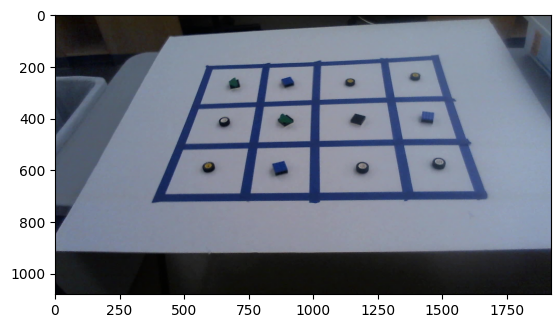

In [7]:
im=imread('images/2011-11-15 - Board Images/output24.jpg')
imshow(im)

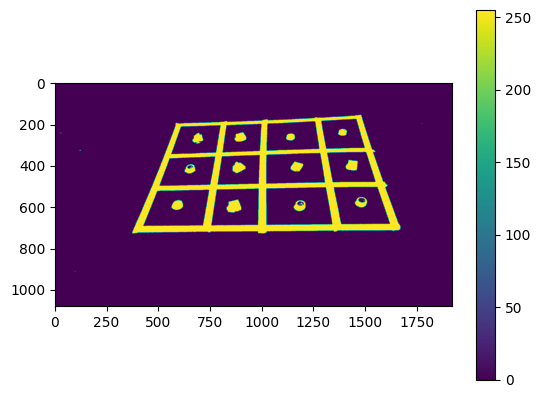

In [8]:
im2=get_threshold_im(im)
imshow(im2)
colorbar()

array([[ 585.,  198.],
       [1477.,  158.],
       [1670.,  696.],
       [ 373.,  728.]], dtype=float32)

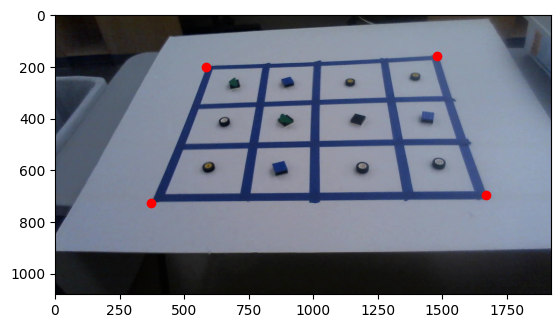

In [17]:
corners=find_corners(im)
imshow(im)

# first column = x, second column=y  (could easily have been row,col)
plot(corners[:,0],corners[:,1],'ro')
corners

Text(0.5, 1.0, 'truncated')

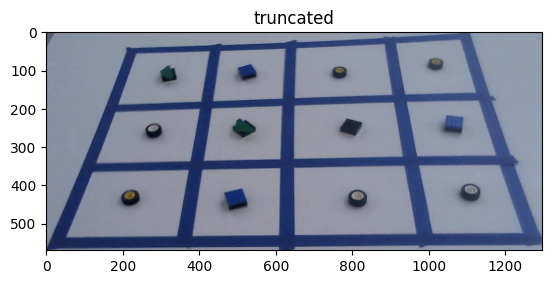

In [19]:
xx=array([min(corners[:,0]),max(corners[:,0])]).astype(int)
yy=array([min(corners[:,1]),max(corners[:,1])]).astype(int)
im2=im[yy[0]:yy[1],xx[0]:xx[1],:]
imshow(im2)
title('truncated')

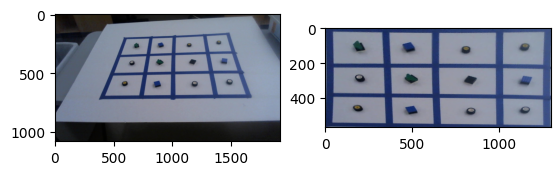

In [10]:
im3=straighten_image(im,corners)

subplot(1,2,1)
imshow(im)

subplot(1,2,2)
imshow(im3)

In [11]:
from Game import Board

Version:  0.3.09


this sample board is weird with 5 different types of pieces and no empty squares.

In [13]:
state=Board('1233/4152/3244')

In [24]:
squares=get_board_squares_from_image(im3,(3,4))

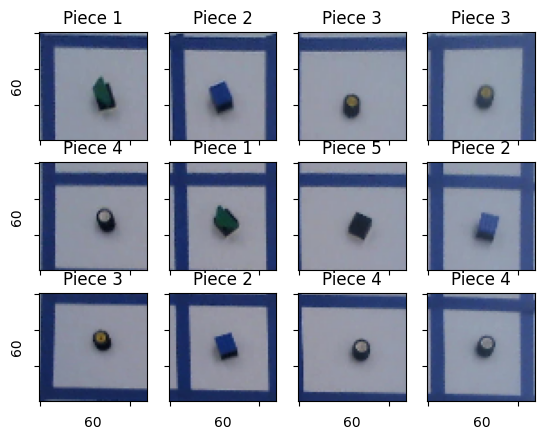

In [26]:
nr,nc=(3,4)
saveit=False

count=0
for r in range(nr):
    for c in range(nc):

        subplot(nr,nc,count+1)
        imshow(squares[count])

        shape=squares[count].shape
        piece=state.board[count]
        
        title(f"Piece {piece}")
        if c==0:
            ylabel(shape[0])

        if r==nr-1:
            xlabel(shape[1])
        gca().set_xticklabels([])
        gca().set_yticklabels([])


        if saveit:
            fname=f"images/square{r}_{c}_{piece}.jpg"
            print(fname)
            imsave(fname,squares[count])
        



        
        count+=1        



what would happen if we didn't straighten and only truncated?

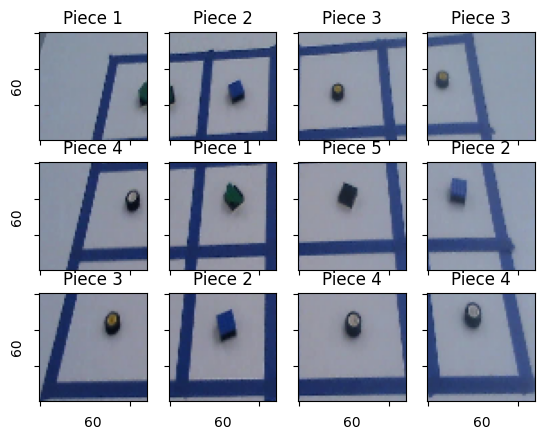

In [27]:
squares=get_board_squares_from_image(im2,(3,4))
nr,nc=(3,4)
saveit=False

count=0
for r in range(nr):
    for c in range(nc):

        subplot(nr,nc,count+1)
        imshow(squares[count])

        shape=squares[count].shape
        piece=state.board[count]
        
        title(f"Piece {piece}")
        if c==0:
            ylabel(shape[0])

        if r==nr-1:
            xlabel(shape[1])
        gca().set_xticklabels([])
        gca().set_yticklabels([])


        if saveit:
            fname=f"images/square{r}_{c}_{piece}.jpg"
            print(fname)
            imsave(fname,squares[count])
        



        
        count+=1        



In [21]:
import os,shutil,glob